### EvaluationSubmissions are evaluated on classification accuracy (the percent of labels that are predicted correctly) for every parsed phrase. The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import re
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [2]:
train_data = pd.read_csv('train.tsv.zip', sep = '\t')
test_data = pd.read_csv('test.tsv.zip', sep = '\t')
print(train_data.head())
print(test_data.head())

   PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2  
   PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly

In [3]:
sub_data = pd.read_csv('sampleSubmission.csv')

sub_data.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


### Exploratory Data Analysis

In [4]:
# Checking the shape of all data
print("train dataset: ",train_data.shape)
print("test dataset: ",test_data.shape)
print("Submission submission: ",sub_data.shape)

train dataset:  (156060, 4)
test dataset:  (66292, 3)
Submission submission:  (66292, 2)


In [5]:
train_data.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


#### There are 2 different data types: int64, object.

In [7]:
# Count of Sentiment Column

train_data['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

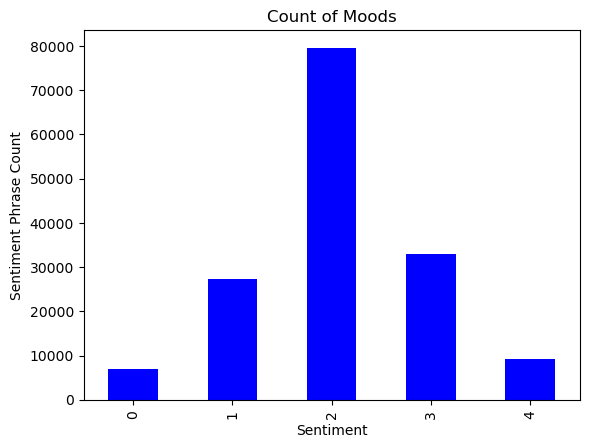

In [8]:
# A quick visualization of the sentiment phrase to see the distribution


train_data['Sentiment'].value_counts().sort_index().plot(kind = "bar", color = "blue")
plt.ylabel('Sentiment Phrase Count')
plt.xlabel('Sentiment')
plt.title('Count of Moods');

In [9]:
word_counts = train_data['Phrase'].apply(lambda x: len(x.split()))
word_counts.describe()
train_data['Sentiment'].value_counts(normalize = True).sort_index()

0    0.045316
1    0.174760
2    0.509945
3    0.210989
4    0.058990
Name: Sentiment, dtype: float64

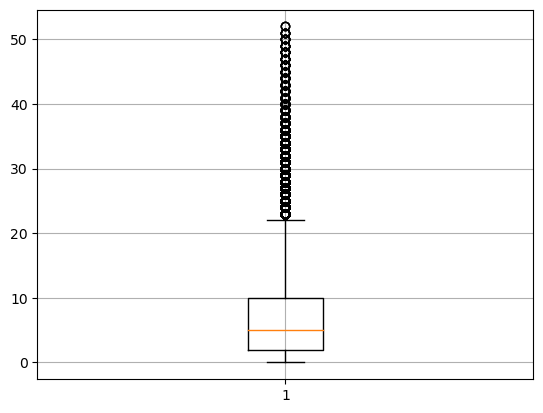

In [10]:
plt.boxplot(word_counts.values)
plt.grid(True)
plt.show()

#### Observations: Most of the reviews/phrases have words between 5 to 10

## Data Preprocessing Phase

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
stemmer  = SnowballStemmer(language='english') #setup for english language
stop_words = stopwords.words('english') # defining stop_words for english language
stop_words.remove('not') # removing not from the stop_words list as it contains value in negative movies reviews
lemmatizer = WordNetLemmatizer()

In [13]:
#function to create tokenizer
def tokenize(text):
    return [stemmer.stem(token) for token in word_tokenize(text)]
#  Lets test the tokenize function
tokenize("Kaggle is a great place to learn data science")

['kaggl', 'is', 'a', 'great', 'place', 'to', 'learn', 'data', 'scienc']

In [14]:
# Let's create a function to clean the Phrase column

def data_preprocess(Phrase):
    Phrase = re.sub(re.compile('<.*?>'), '', Phrase) #removing html tags if any
    Phrase =  re.sub('[^A-Za-z0-9]+', ' ', Phrase) #taking only words
    Phrase = Phrase.lower()   # making all phrases lower case
    tokens = nltk.word_tokenize(Phrase) # converts Phrases to tokens
    Phrase = [word for word in tokens if word not in stop_words] #removing stop words
    Phrase = [lemmatizer.lemmatize(word) for word in Phrase]   # lemmatization
    Phrase = ' '.join(Phrase)  # join words in preprocessed Phrase
    
    return Phrase

In [15]:
train_data['Preprocessed_phrase'] = train_data['Phrase'].apply(lambda Phrase: data_preprocess(Phrase))
train_data.head(200)

,PhraseId,SentenceId,Phrase,Sentiment,Preprocessed_phrase
0,1,1,A series of escapades demonstrating the adage ...,1,series escapade demonstrating adage good goose...
1,2,1,A series of escapades demonstrating the adage ...,2,series escapade demonstrating adage good goose
2,3,1,A series,2,series
3,4,1,A,2,
4,5,1,series,2,series
...,...,...,...,...,...
195,196,6,midlife crisis,1,midlife crisis
196,197,6,midlife,2,midlife
197,198,6,crisis,2,crisis
198,199,7,"Narratively , Trouble Every Day is a plodding ...",1,narratively trouble every day plodding mess


In [16]:
test_data['Preprocessed_phrase'] = train_data['Phrase'].apply(lambda Phrase: data_preprocess(Phrase))
test_data.head()

,PhraseId,SentenceId,Phrase,Preprocessed_phrase
0,156061,8545,An intermittently pleasing but mostly routine ...,series escapade demonstrating adage good goose...
1,156062,8545,An intermittently pleasing but mostly routine ...,series escapade demonstrating adage good goose
2,156063,8545,An,series
3,156064,8545,intermittently pleasing but mostly routine effort,
4,156065,8545,intermittently pleasing but mostly routine,series


### Visualising the positive reviews in word cloud

In [17]:
# Creating a new column with a 'for loop and if statement' from the Sentiment column

Sentiment_phrase =[]

for row in train_data['Sentiment']:
    if row == 0:
        Sentiment_phrase.append('negative')
    elif row == 1:
        Sentiment_phrase.append('somewhat negative')
    elif row == 2:
        Sentiment_phrase.append('neutral')
    elif row == 3:
        Sentiment_phrase.append('somewhat positive')
    elif row == 4:
        Sentiment_phrase.append('positive')
    else:
        Sentiment_phrase.append('Failed')
        
        
train_data['Sentiment_phrase'] = Sentiment_phrase

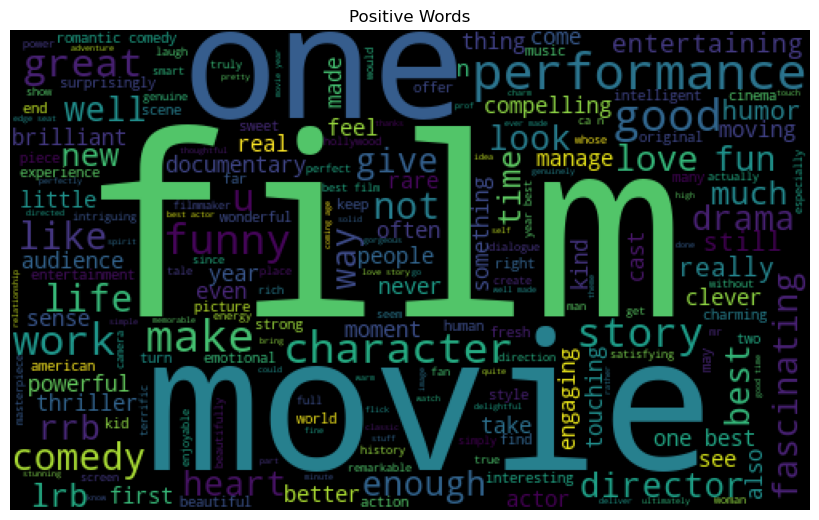

In [18]:
from wordcloud import WordCloud

words_list = train_data[train_data['Sentiment_phrase']=='positive']['Preprocessed_phrase'].unique().tolist()
positive_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=500, height = 300,            
                  stopwords=stop_words).generate(positive_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Positive Words')
plt.show()

### Visualising the Negative reviews in word cloud

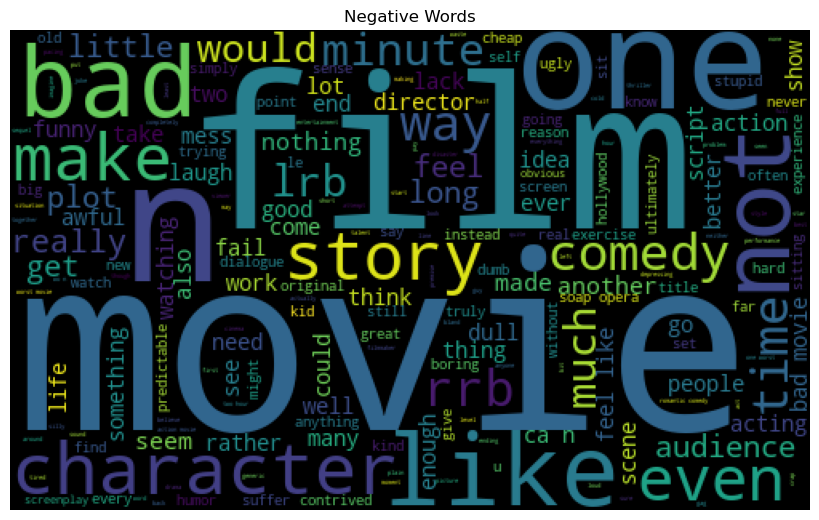

In [19]:
words_list = train_data[train_data['Sentiment_phrase']=='negative']['Preprocessed_phrase'].unique().tolist()
positive_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=500, height = 300,            
                  stopwords=stop_words).generate(positive_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Negative Words')
plt.show()

In [22]:
train_df = train_data.copy()
y_train = train_df['Sentiment'].values
X_train = train_df.drop(['Sentiment'], axis = 1)
X_train.drop(['Sentiment_phrase'], axis = 1, inplace = True)
X_test = test_data.copy()
y_test = sub_data['Sentiment'].values
print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (156060, 4) (156060,)
Test data: (66292, 4) (66292,)


### Vectorizing the Text Data
In the next step, we will transfer the pre-processed phrase column to a vector representation. The vector representations allows us to train a model based on numerical representations. In this case, we will use CountVectorizer(Bag of Words).

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_train_phrase_bow = vectorizer.fit_transform(X_train['Preprocessed_phrase'])
X_test_phrase_bow = vectorizer.transform(X_test['Preprocessed_phrase'])

print('X_train_phrase_bow shape: ', X_train_phrase_bow.shape)
print('X_test_phrase_bow shape: ', X_test_phrase_bow.shape)

X_train_phrase_bow shape:  (156060, 13740)
X_test_phrase_bow shape:  (66292, 13740)


### Model Building
#### Naive Bayes: BOW
Let's train a Multinomial Naive Bayes classifier and evaluate its performance

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

clf = MultinomialNB()
clf.fit(X_train_phrase_bow, y_train)

y_pred = clf.predict(X_test_phrase_bow) #prediction from model
print('Test Accuracy: ', accuracy_score(y_test, y_pred)) 

Test Accuracy:  0.6075695408194051


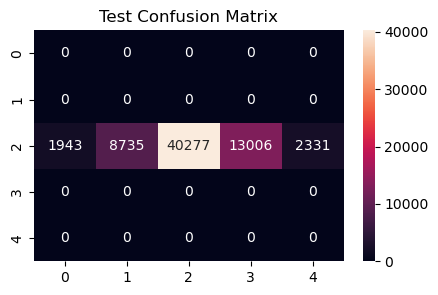

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

#### Random Forest: BOW
Let's train a Random Forest classifier and evaluate its performance

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier()
clf.fit(X_train_phrase_bow, y_train)

y_pred = clf.predict(X_test_phrase_bow) #prediction from model
print('Test Accuracy: ', accuracy_score(y_test, y_pred)) 

Test Accuracy:  0.5512128160260665


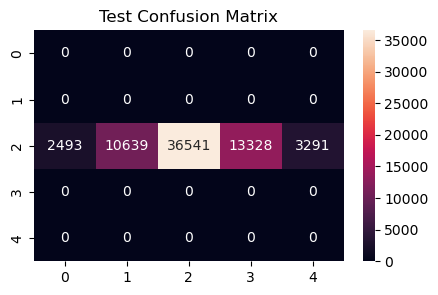

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

### Vectorizing the Text Data
In the next step, we will transfer the pre-processed phrase column to a vector representation. The vector representations allows us to train a model based on numerical representations. In this case, we will use TfIdfVectorizer(Tf-Idf).

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train_phrase_tfidf = vectorizer.fit_transform(X_train['Preprocessed_phrase'])
X_test_phrase_tfidf = vectorizer.transform(X_test['Preprocessed_phrase'])

print('X_train_phrase_tfidf shape: ', X_train_phrase_tfidf.shape)
print('X_test_phrase_tfidf shape: ', X_test_phrase_tfidf.shape)

X_train_phrase_tfidf shape:  (156060, 13740)
X_test_phrase_tfidf shape:  (66292, 13740)


#### Random Forest: TFIDF
Let's train a Random Forest classifier and evaluate its performance

In [29]:
lf = RandomForestClassifier()
clf.fit(X_train_phrase_tfidf, y_train)

y_pred = clf.predict(X_test_phrase_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.5527062088939841


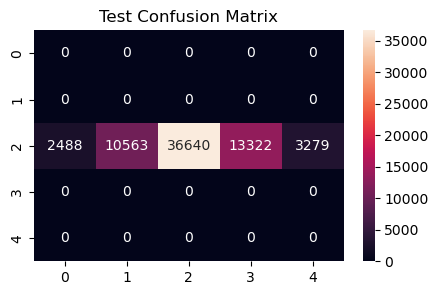

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

#### Naive Bayes: TFIDF
Let's train a Naive Bayes classifier and evaluate its performance

In [31]:
lf = MultinomialNB(alpha=1)
clf.fit(X_train_phrase_tfidf, y_train)

y_pred = clf.predict(X_test_phrase_tfidf)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test Accuracy:  0.5528872262113076


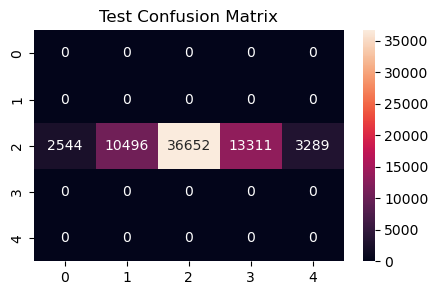

In [32]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()